In [1]:
import typing as tp
from enum import Enum
from copy import deepcopy

import numpy as np
from numpy import typing as npt
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    Normalizer,
)
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

sns.set(style="darkgrid", font_scale=1.0, palette="viridis")


# Домашнее задание №1. Softmax Regression.

Нужно реализовать много-классовую логистическую регрессию с помощью softmax c поддержкой L1/L2 регуляризации. После этого сравнить с sklearn реализацией [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
 с настройкой **multinomial**.

## Задание №1 (10 баллов)

Реализовать класс SoftMaxRegression и его методы - init, fit, predict c возможностью конфигурации
регуляризации. 
Для оптимизации функции ошибки воспользоваться методом **стохастического градиентного спуска**. 

Остальные функции реализовать на ваше усмотрение. 

Имеем такой лосс:

$$
\begin{array}{l}
\mathcal{L}_{W,b}( x,y) =-\frac{1}{N}\sum _{i=1}^{N}\sum _{c=1}^{C} y_{i,c}\log( p_{i,c}) =-\frac{1}{N}\sum _{i=1}^{N}\sum _{c=1}^{C} y_{i,c}\log\left(\frac{e^{( x_{i} W+b)_{c}}}{\sum _{k=1}^{C} e^{( x_{i} W+b)_{k}}}\right) =\\
=-\frac{1}{N}\sum _{i=1}^{N}\log\left(\frac{e^{( x_{i} W+b) y_{i}^{T}}}{\sum _{k=1}^{C} e^{( x_{i} W+b)_{k}}}\right) =-\frac{1}{N}\sum _{i=1}^{N}( x_{i} W+b) y_{i}^{T} +\frac{1}{N}\sum _{i=1}^{N}\log\left(\sum _{k=1}^{C} e^{( x_{i} W+b)_{k}}\right)
\end{array}
$$

Продифференицруем его и получим такие градиенты:

$$
\begin{array}{l}
\nabla _{W_{k}}\mathcal{L}_{W,b}( x,y) =-\frac{1}{N}\sum _{i=1}^{N} y_{i,k} x_{i} +\frac{1}{N}\sum _{i=1}^{N}\frac{e^{x_{i} W_{k} +b_{k}} x_{i}}{\sum _{c=1}^{C} e^{( x_{i} W+b)_{c}}} =\\
=\frac{1}{N}\sum _{i=1}^{N}\left(\frac{e^{x_{i} W_{k} +b_{k}}}{\sum _{c=1}^{C} e^{( x_{i} W+b)_{c}}} -y_{i,k}\right) x_{i}
\end{array}
$$

Значит:

$$
\begin{array}{l}
\nabla _{W}\mathcal{L}_{W,b}( x,y) =\frac{1}{N}\left( X^{T}( P-Y_{oh})\right)\\
\nabla _{b}\mathcal{L}_{W,b}( x,y) =-\frac{1}{N}\sum _{i=1}^{N} y_{i} +\frac{1}{N}\sum _{i=1}^{N}\frac{e^{x_{i} W +b}}{\sum _{c=1}^{C} e^{( x_{i} W+b)_{c}}}
\end{array}
$$

In [2]:
def softmax(X: npt.ArrayLike) -> npt.ArrayLike:
    exp = np.exp(X)
    return exp / np.sum(exp, axis=1)[:, None]


In [3]:
class SoftMaxRegression:
    def __init__(
        self,
        penalty: str = "l2",
        fit_intercept: bool = True,
        random_state: int = None,
        C: float = 1.0,
        batch_size: int = 32,
        lr: float = 1e-3,
        tol: float = 1e-6,
        max_iter: int = 500,
        verbose: int = 0,
        warm_start: bool = False,
        metrics: tp.Callable = accuracy_score,
        momentum: float = 0.999,
        lr_decay: float = None,
        lr_decay_freq=None,
    ):
        self.penalty = penalty
        self.fit_intercept = fit_intercept
        self.C = C
        self.fitted = False
        self.oh = OneHotEncoder(sparse=False, handle_unknown="ignore")
        self.loss_history = []
        self.val_loss = []
        self.score_hist = []
        self.metrics = metrics
        self.lr = lr
        self.tol = tol
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.warm_start = warm_start
        self.random_state = random_state
        self.momentum = momentum
        self.lr_decay = 1.0 if lr_decay is None else lr_decay
        self.lr_decay_freq = [] if lr_decay_freq is None else lr_decay_freq
        if type(lr_decay_freq) == int:
            self.lr_decay_freq = np.arange(0, self.max_iter, lr_decay_freq)

    def fit(self, X: np.array, Y: np.array) -> "SoftMaxRegression":
        """функция обучения модели"""
        X = np.array(X)
        Y = np.array(Y)
        X_train, X_val, Y_train, Y_val = train_test_split(
            X, Y, test_size=0.1, random_state=self.random_state
        )
        Y_train = self.oh.fit_transform(Y_train.reshape(-1, 1))
        self.n_features = X_train.shape[1]
        self.n_classes = Y_train.shape[1]
        if not self.warm_start:
            self.W, self.b = self._init_weights()
            if not self.fit_intercept:
                self.b *= 0.0
            self.loss_history.clear()
            self.score_hist.clear()
            self.val_loss.clear()
        self._SGD(X_train, Y_train, X_val, Y_val)
        self.fitted = True
        return self

    def predict(self, X_test: np.array) -> np.array:
        """функция предсказания"""
        X_test = np.array(X_test)
        if not self.fitted:
            print("WARNING: Predicting without fitting, behaviour is undefined.")
            return np.zeros(shape=X_test.shape[0], dtype=np.int32)
        return self._logits_to_classes(self._get_logits(X_test))

    def predict_proba(self, X_test: np.array) -> np.array:
        """функция предсказания"""
        X_test = np.array(X_test)
        if not self.fitted:
            print("WARNING: Predicting without fitting, behaviour is undefined.")
            return np.zeros(shape=X_test.shape[0], dtype=np.int32)
        return softmax(self._get_logits(X_test))

    def _get_logits(self, X: np.array) -> np.array:
        logits = np.zeros(shape=(X.shape[0], self.n_classes))
        np.matmul(X, self.W, out=logits)
        if self.fit_intercept:
            np.add(logits, self.b, out=logits)
        return logits

    def _logits_to_classes(self, logits: np.array) -> np.array:
        return np.argmax(softmax(logits), axis=-1).astype(np.int32)

    def _init_weights(self) -> np.array:
        stdv = 1.0 / np.sqrt(self.n_features)
        distr = sps.uniform(loc=-stdv, scale=2 * stdv)
        return (
            distr.rvs(
                size=(self.n_features, self.n_classes), random_state=self.random_state
            ),
            distr.rvs(size=(self.n_classes,), random_state=self.random_state),
        )

    def _regularization(self) -> "float":
        regul = 0.0
        if self.penalty == "l2":
            regul = np.sum(np.square(self.W))
        elif self.penalty == "l1":
            regul = np.sum(np.abs(self.W))
        return regul

    def _grad_regul(self) -> np.array:
        derivative = np.zeros_like(a=self.W)
        if self.penalty == "l2":
            derivative += self.W
            derivative *= 2
        elif self.penalty == "l1":
            derivative += np.sign(self.W)
        return derivative

    def _loss(self, X_batch: np.array, Y_batch: np.array) -> float:
        N = X_batch.shape[0]
        logits = self._get_logits(X_batch)
        prod = np.zeros(shape=(N, N))
        np.matmul(logits, Y_batch.T, out=prod)
        trace = np.trace(prod)

        log = np.zeros(shape=logits.shape[0])
        logits_exp = np.zeros_like(a=logits)
        np.exp(logits, out=logits_exp)
        np.sum(logits_exp, axis=1, out=log)
        np.log(log, out=log)
        # print(f"prod_shape: {prod.shape}, log_shape: {log.shape}")
        return (np.sum(log) - trace) / N

    def _loss_grad(self, X_batch: np.array, Y_batch: np.array) -> float:
        N = X_batch.shape[0]
        P = softmax(self._get_logits(X_batch))
        prod = np.zeros_like(a=self.W)
        sum = np.zeros_like(a=self.b)
        diff = np.zeros_like(a=P)
        np.subtract(P, Y_batch, out=diff)
        np.matmul(X_batch.T, diff, out=prod)
        np.sum(diff, axis=0, out=sum)
        prod /= N
        sum /= N
        factor = self.C
        if self.penalty == "l2":
            factor *= 2
        return prod + (self._grad_regul() / factor), sum

    def _get_batch(self, X_train: np.array, Y_train: np.array):
        n_samples = X_train.shape[0]
        indices = np.arange(n_samples)
        rs = np.random.RandomState(self.random_state)
        rs.shuffle(indices)
        for start in range(0, n_samples, self.batch_size):
            end = min(start + self.batch_size, n_samples)
            batch_idx = indices[start:end]
            yield X_train[batch_idx], Y_train[batch_idx]

    def _SGD(
        self, X_train: np.array, Y_train: np.array, X_val: np.array, Y_val: np.array
    ):
        Y_val_oh = self.oh.transform(Y_val.reshape((-1, 1)))
        prev_W = np.zeros_like(a=self.W)
        old_grad = np.zeros_like(a=self.W)
        old_grad_b = np.zeros_like(a=self.b)
        best_val_loss = np.inf
        step = 0
        epoch_num = 1
        to_stop = False
        while not to_stop:
            for X_batch, Y_batch in self._get_batch(X_train, Y_train):
                curr_lr = self.lr
                if step in self.lr_decay_freq:
                    curr_lr /= 1 + (self.lr_decay * epoch_num)

                factor = self.C
                if self.penalty == "l2":
                    factor *= 2
                regul = self._regularization() / factor
                train_loss = self._loss(X_batch, Y_batch) + regul
                val_loss = self._loss(X_val, Y_val_oh) + regul
                curr_preds = self._logits_to_classes(self._get_logits(X_val))
                score = self.metrics(curr_preds, Y_val)

                # check stopping criteria
                if step >= self.max_iter or (
                    step >= 1 and best_val_loss - val_loss <= self.tol
                ):
                    to_stop = True
                    break

                self.loss_history.append(train_loss)
                self.val_loss.append(val_loss)
                self.score_hist.append(score)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss

                gradW, gradB = self._loss_grad(X_batch, Y_batch)
                np.add(
                    self.momentum * old_grad,
                    curr_lr * gradW,
                    out=old_grad,
                )
                np.subtract(self.W, old_grad, out=self.W)
                if self.fit_intercept:
                    np.add(
                        self.momentum * old_grad_b,
                        curr_lr * gradB,
                        out=old_grad_b,
                    )
                    np.subtract(self.b, old_grad_b, out=self.b)
                step += 1
            epoch_num += 1
        if step == self.max_iter:
            print(f"WARNING: SGD didn't converge in {step} steps.")

    def __repr__(self):
        self_dict = vars(self)
        str_res = f"{str(self.__class__.__name__)}("
        no_display_attributes = [
            "loss_history",
            "W",
            "oh",
            "classes_",
            "val_loss",
            "metrics",
            "score_hist",
            "lr_decay_freq",
            "b",
        ]
        for key in self_dict:
            if key in no_display_attributes:
                continue
            str_res = f"{str_res}{key}={str(self_dict[key])}, "
        return f"{str_res[:-2]})"


## Задание №2 (10 баллов)

Загрузите любой датасет много-классовой классификации, сделайте предобработку, разбейте на тренировочную и тестовую выборку  и оцените работу вашего алгоритма. Предпочтительно использовать метрику точности(accuracy) для оценки алгоритма. 

В рамках оценки, воспользуйтесь sklearn реализацией много-классовой логистической регрессии. **Проверьте что ваши метрики совпадают(+/-1-2%) на моделях без регуляризации, с L1 и с L2 регуляризации.**

#### Работа с датасетом (1 балл)

Загрузите выбранный датасет много-классовой классификации, обработайте его, сделайте разбиение на тренировочную и тестовую выборку. Датасеты для классификации можно взять например [**отсюда**](https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table).

In [4]:
! gdown https://drive.google.com/uc?id=1wQgPYfbdnzJSCxDtpB1wCKx4eJR8K7H5

/bin/bash: /home/akhmadjonov/miniconda3/envs/dgac/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Downloading...
From: https://drive.google.com/uc?id=1wQgPYfbdnzJSCxDtpB1wCKx4eJR8K7H5
To: /cephfs/home/akhmadjonov/workspace/notebooks/SberTech/task1/dry_bean_data.csv
100%|██████████████████████████████████████| 2.48M/2.48M [00:00<00:00, 13.9MB/s]


In [5]:
GLOBAL_RANDOM_STATE = 42


In [6]:
bean_raw_data = pd.read_csv("./dry_bean_data.csv", sep=";")
bean_raw_data.shape, bean_raw_data.dropna().shape, bean_raw_data.drop_duplicates().shape


((13611, 17), (13611, 17), (13543, 17))

In [7]:
bean_raw_data.drop_duplicates(inplace=True)


In [8]:
classes = np.unique(bean_raw_data["Class"])
class_to_id = dict(zip(classes, np.arange(len(classes))))
id_to_class = {class_to_id[clazz]: clazz for clazz in class_to_id}
id_to_class


{0: 'BARBUNYA',
 1: 'BOMBAY',
 2: 'CALI',
 3: 'DERMASON',
 4: 'HOROZ',
 5: 'SEKER',
 6: 'SIRA'}

In [9]:
labels = bean_raw_data["Class"].apply(lambda x: class_to_id[x])
data_no_labels = bean_raw_data.drop(columns=["Class"])


In [10]:
for column in data_no_labels.select_dtypes(include=["object"]).columns:
    data_no_labels[column] = (
        data_no_labels[column].str.replace(",", ".").astype(np.float32)
    )
data_no_labels.tail(5)


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
13606,42097,759.695984,288.721619,185.944702,1.552728,0.765002,42508,231.515793,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385
13607,42101,757.499023,281.576385,190.713135,1.476439,0.735702,42494,231.526794,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219
13608,42139,759.320984,281.539917,191.187973,1.472582,0.734065,42569,231.631256,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767
13609,42147,763.778992,283.382629,190.275726,1.489326,0.741055,42667,231.653244,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222
13610,42159,772.237000,295.142731,182.204712,1.619841,0.786693,42600,231.686218,0.788962,0.989648,0.888380,0.784997,0.007001,0.001640,0.616221,0.998180


In [11]:
data_no_labels.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13543 entries, 0 to 13610
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13543 non-null  int64  
 1   Perimeter        13543 non-null  float32
 2   MajorAxisLength  13543 non-null  float32
 3   MinorAxisLength  13543 non-null  float32
 4   AspectRation     13543 non-null  float32
 5   Eccentricity     13543 non-null  float32
 6   ConvexArea       13543 non-null  int64  
 7   EquivDiameter    13543 non-null  float32
 8   Extent           13543 non-null  float32
 9   Solidity         13543 non-null  float32
 10  roundness        13543 non-null  float32
 11  Compactness      13543 non-null  float32
 12  ShapeFactor1     13543 non-null  float32
 13  ShapeFactor2     13543 non-null  float32
 14  ShapeFactor3     13543 non-null  float32
 15  ShapeFactor4     13543 non-null  float32
dtypes: float32(14), int64(2)
memory usage: 1.0 MB


Резделим датасет на обучающую и тестовые выборки и посмотрим на некоторые свойства данных:

In [12]:
data_numpy, labels_numpy = data_no_labels.to_numpy(
    dtype=np.float32, copy=True
), labels.to_numpy(dtype=np.int32, copy=True)


In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(
    data_numpy, labels_numpy, test_size=0.2, random_state=GLOBAL_RANDOM_STATE
)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape


((10834, 16), (2709, 16), (10834,), (2709,))

In [14]:
X_train_pd = pd.DataFrame(X_train, columns=data_no_labels.columns)
X_train_pd.describe()


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
count,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000,10834.000000
mean,53026.789062,855.063843,319.883667,202.355957,1.580846,0.750281,53747.179688,253.020462,0.749745,0.987124,0.873482,0.800391,0.006560,0.001720,0.644399,0.995054
std,29261.531250,214.279510,85.741318,44.825855,0.245048,0.091716,29710.675781,59.133480,0.048982,0.004675,0.059584,0.061431,0.001128,0.000596,0.098593,0.004375
min,20464.000000,524.736023,183.965256,129.576202,1.024868,0.218951,20772.000000,161.417389,0.555315,0.919246,0.489618,0.640577,0.002778,0.000564,0.410339,0.947687
25%,36266.250000,703.247726,252.797333,175.638832,1.430540,0.715086,36658.500000,214.885139,0.718678,0.985611,0.833121,0.762899,0.005888,0.001156,0.582014,0.993676
50%,44554.500000,793.756012,296.187607,192.623138,1.549440,0.763849,45090.000000,238.177559,0.759494,0.988272,0.883347,0.801641,0.006641,0.001702,0.642628,0.996396
75%,61567.250000,978.766510,376.557777,217.345287,1.704867,0.809909,62530.750000,279.981880,0.786871,0.989990,0.916986,0.834558,0.007279,0.002176,0.696488,0.997887
max,254616.000000,1985.369995,738.860168,460.198486,2.430306,0.911423,263261.000000,569.374329,0.866195,0.994677,0.987920,0.987303,0.009897,0.003665,0.974767,0.999733


На глаз оценим какие признаки распределены нормально:

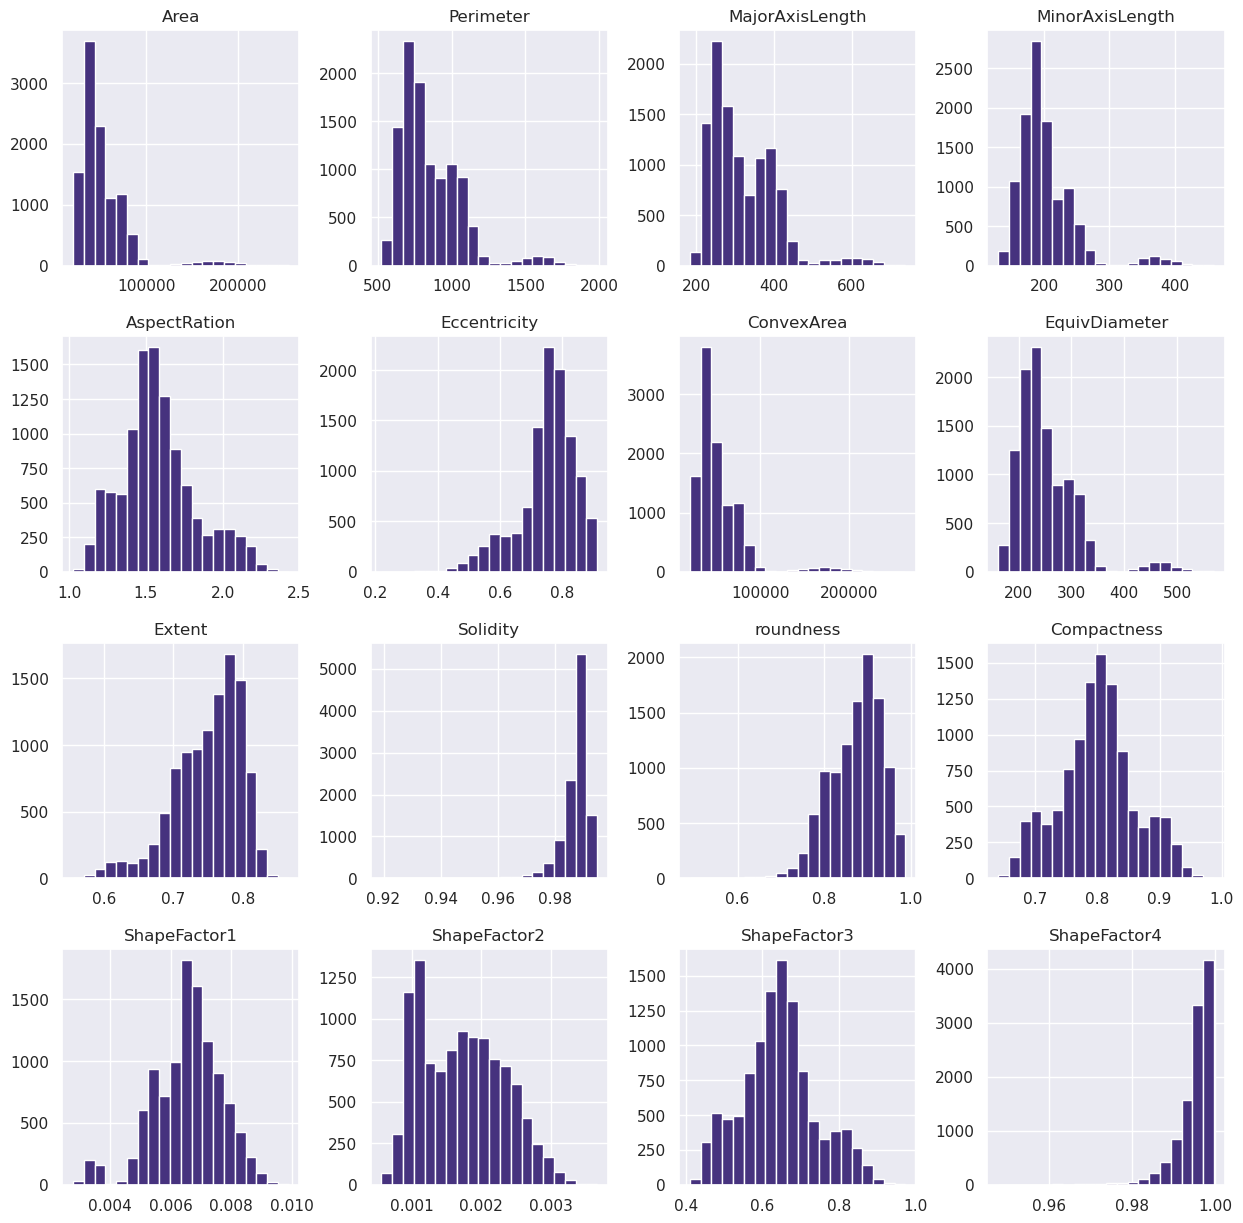

In [15]:
X_train_pd.hist(figsize=(15, 15), bins=20)
plt.show()


Теперь формально определим какие признаки распределены нормально:

In [16]:
from scipy.stats import normaltest

norm_features = []

for col in X_train_pd.columns:
    stat, p = normaltest(X_train_pd[col].values)
    if p > 0.05:
        norm_features.append(col)

norm_features


[]

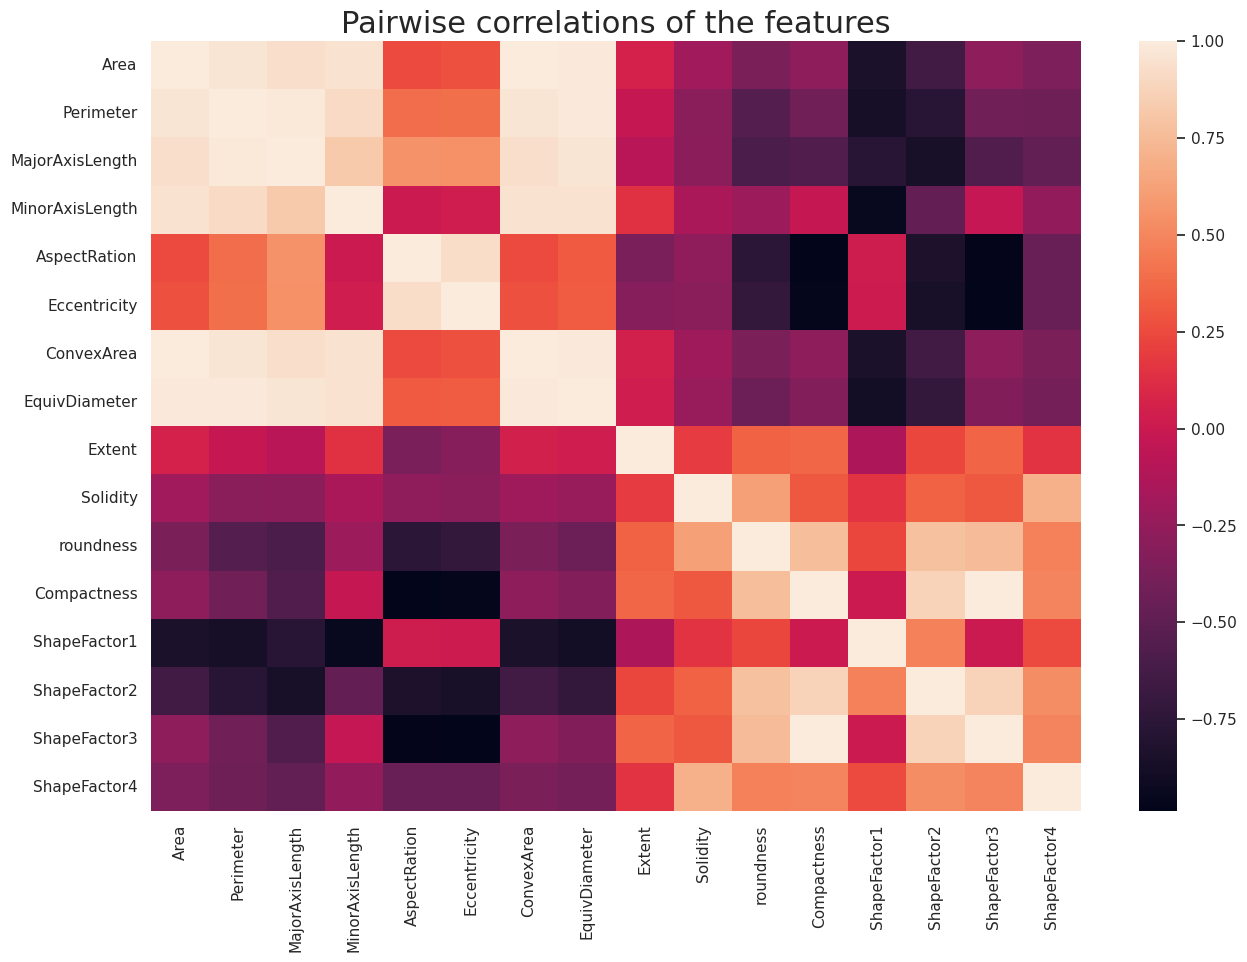

In [17]:
corr = X_train_pd.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr)
plt.title("Pairwise correlations of the features", fontsize=22)
plt.show()


In [18]:
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[0]):
        if corr.iloc[i, j] >= 0.9 or corr.iloc[i, j] <= -0.9:
            if columns[j]:
                columns[j] = False

selected_columns = X_train_pd.columns[columns]
selected_columns


Index(['Area', 'AspectRation', 'Extent', 'Solidity', 'roundness',
       'ShapeFactor2', 'ShapeFactor4'],
      dtype='object')

Пока не станем убирать коррелирующие признаки и посмотрим как регуляризации модели справятся с оверфитом, и заодно сравним работу моделей с регуляризацией и без.

Посмотрим сколько у нас аутлаеров и выкинем их:

In [19]:
print(X_train_pd.shape)
non_outlier_idx = np.abs(sps.zscore(X_train_pd) < 4).all(axis=1)
X_train_no = X_train_pd[non_outlier_idx].to_numpy()
Y_train_no = Y_train[non_outlier_idx.values]
print(X_train_no.shape, Y_train_no.shape)


(10834, 16)
(10606, 16) (10606,)


Постандартизуем данные:

In [20]:
std_scaler = StandardScaler()
X_train_tr = std_scaler.fit_transform(X_train_no)
X_test_tr = std_scaler.fit_transform(X_test)


#### Обучение модели и сравнение с sklearn имплементацией

Обучите 3 модели - обычную, с L1 реализацией, с L2 реализацией и сравните с аналогичными sklearn имплементациями много-классовой логистической регрессии. 

В рамках обучения модели требуется визуализировать:

1) График падания значений ошибки на тренировочной выборке в зависимости от итерации.
2) График падания значений ошибки на валидационной выборке в зависимости от итерации.
3) График роста метрики точности в зависимости от итерации.

<span style="color:red">**Модель считается успешно реализованной, если целевая метрика совпадает с sklearn реализацией. Если разница большая(более 2%), баллы за ДЗ не проставляются.**</span>


In [21]:
def draw_train_log(model: "SoftMaxRegression"):
    colors = sns.color_palette("Set1")
    plt.figure(figsize=(15, 8))
    sns.lineplot(data=model.loss_history, label="train_loss", color=colors[1])
    sns.lineplot(data=model.val_loss, label="val_loss", color=colors[4])
    sns.lineplot(data=model.score_hist, label="accuracy", color=colors[2])
    plt.xlabel("#iter")
    plt.ylabel("loss")
    plt.title("Loss and metrics by iterations")
    plt.show()


#### Обучение обычной модели и сравнение с __LogisticRegression(penalty = 'none', multi_class='multinomial')__ (3 балла)

In [22]:
gold_model = LogisticRegression(
    penalty="none",
    multi_class="multinomial",
    solver="saga",
    random_state=GLOBAL_RANDOM_STATE,
)
gold_model.fit(X_train_tr, Y_train_no)
gold_preds = gold_model.predict(X_test_tr)
gold_scores = accuracy_score(gold_preds, Y_test)
print(gold_scores)


0.9102990033222591


/home/akhmadjonov/miniconda3/envs/dgac/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


0.8973791066814323


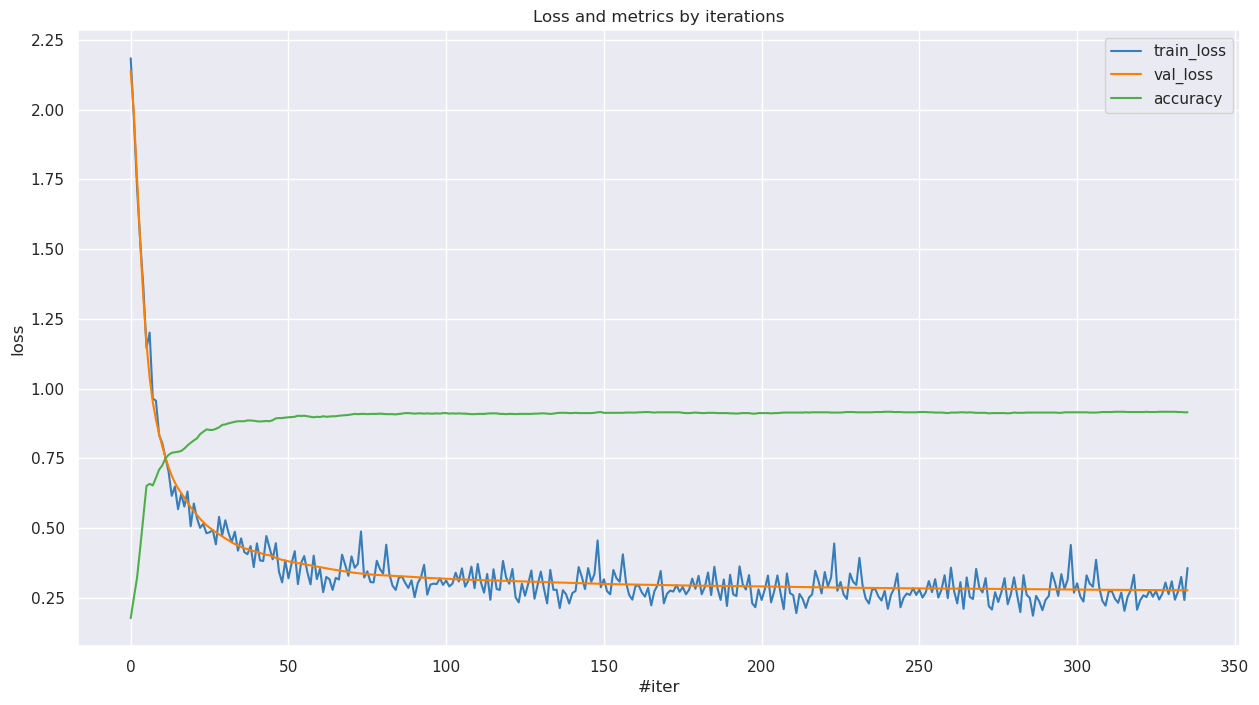

In [23]:
model = SoftMaxRegression(
    penalty="none",
    lr=14.0,
    max_iter=500,
    lr_decay=150.0,
    lr_decay_freq=1,
    momentum=0.8,
    random_state=GLOBAL_RANDOM_STATE,
    batch_size=128,
)
model.fit(X_train_tr, Y_train_no)
preds = model.predict(X_test_tr)
scores = accuracy_score(preds, Y_test)
print(scores)
draw_train_log(model)


In [24]:
assert (gold_scores - scores) * 100 < 2


In [25]:
print(model)


SoftMaxRegression(penalty=none, fit_intercept=True, C=1.0, fitted=True, lr=14.0, tol=1e-06, max_iter=500, batch_size=128, warm_start=False, random_state=42, momentum=0.8, lr_decay=150.0, n_features=16, n_classes=7)


#### Обучение модели c L1 регуляризацией и сравнение с __LogisticRegression(penalty = 'l1', multi_class='multinomial')__ (3 балла)

In [26]:
gold_model_l1 = LogisticRegression(
    penalty="l1",
    multi_class="multinomial",
    solver="saga",
    random_state=GLOBAL_RANDOM_STATE,
    C=300.0,
)
gold_model_l1.fit(X_train_tr, Y_train_no)
gold_preds_l1 = gold_model_l1.predict(X_test_tr)
gold_score_l1 = accuracy_score(gold_preds_l1, Y_test)
print(gold_score_l1)


0.9102990033222591


/home/akhmadjonov/miniconda3/envs/dgac/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


0.8940568475452196


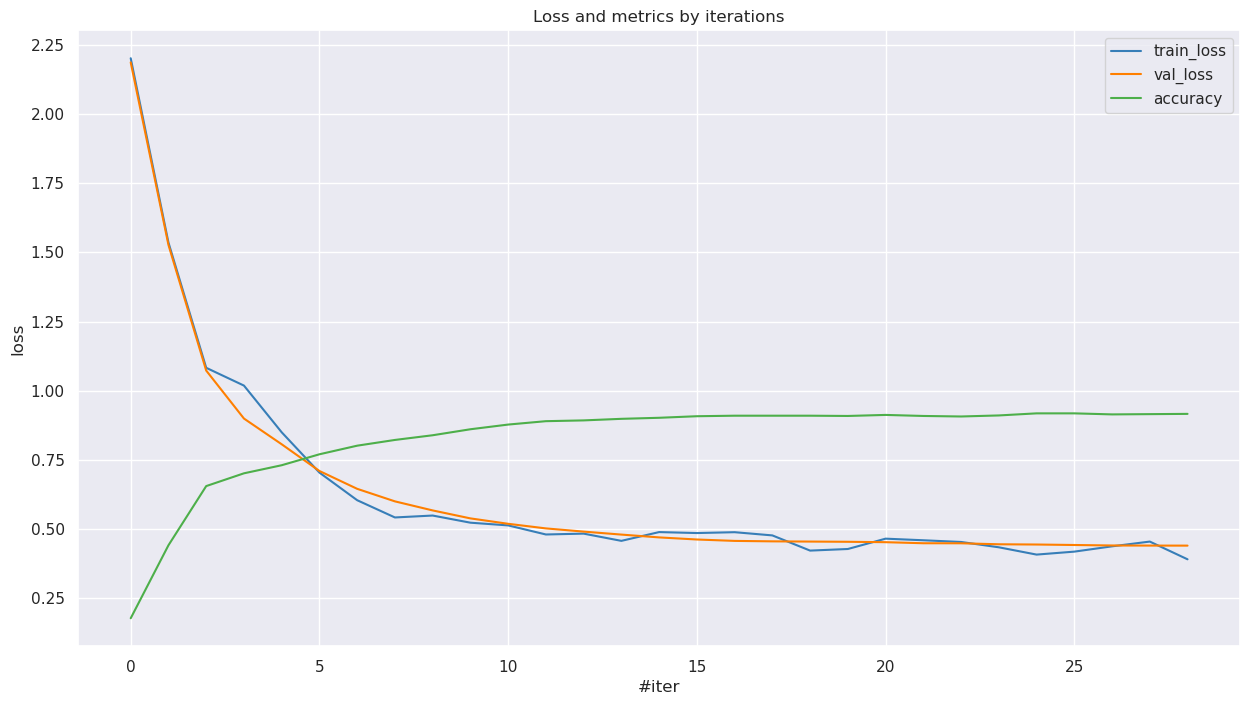

In [27]:
model_l1 = SoftMaxRegression(
    penalty="l1",
    C=300.0,
    lr=35,
    max_iter=500,
    lr_decay=70.0,
    lr_decay_freq=1,
    random_state=GLOBAL_RANDOM_STATE,
    batch_size=256,
    momentum=0.8,
)
model_l1.fit(X_train_tr, Y_train_no)
preds_l1 = model_l1.predict(X_test_tr)
scores_l1 = accuracy_score(preds_l1, Y_test)
print(scores_l1)
draw_train_log(model_l1)


In [28]:
print(model_l1)


SoftMaxRegression(penalty=l1, fit_intercept=True, C=300.0, fitted=True, lr=35, tol=1e-06, max_iter=500, batch_size=256, warm_start=False, random_state=42, momentum=0.8, lr_decay=70.0, n_features=16, n_classes=7)


#### Обучение модели c L2 регуляризацией и сравнение с __LogisticRegression(penalty = 'l2', multi_class='multinomial')__ (3 балла)

In [29]:
gold_model_l2 = LogisticRegression(
    penalty="l2",
    multi_class="multinomial",
    solver="saga",
    random_state=GLOBAL_RANDOM_STATE,
    C=500.0,
)
gold_model_l2.fit(X_train_tr, Y_train_no)
gold_preds_l2 = gold_model_l2.predict(X_test_tr)
gold_score_l2 = accuracy_score(gold_preds_l2, Y_test)
print(gold_score_l2)


0.9102990033222591


/home/akhmadjonov/miniconda3/envs/dgac/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


0.8973791066814323


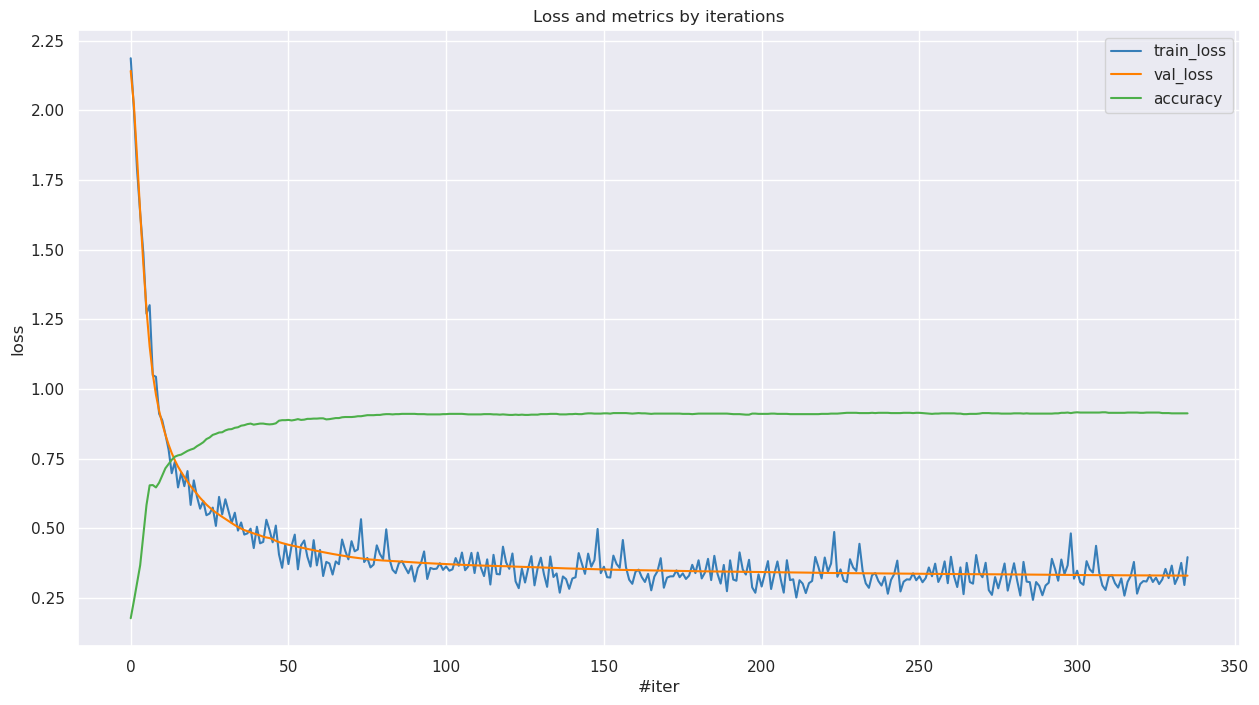

In [30]:
model_l2 = SoftMaxRegression(
    penalty="l2",
    C=500.0,
    lr=3.7,
    max_iter=500,
    lr_decay=50.0,
    lr_decay_freq=1,
    random_state=GLOBAL_RANDOM_STATE,
    batch_size=128,
    momentum=0.8,
    tol=1e-9,
)
model_l2.fit(X_train_tr, Y_train_no)
preds_l2 = model_l2.predict(X_test_tr)
scores_l2 = accuracy_score(preds_l2, Y_test)
print(scores_l2)
draw_train_log(model_l2)


In [31]:
print(model_l2)


SoftMaxRegression(penalty=l2, fit_intercept=True, C=500.0, fitted=True, lr=3.7, tol=1e-09, max_iter=500, batch_size=128, warm_start=False, random_state=42, momentum=0.8, lr_decay=50.0, n_features=16, n_classes=7)


In [43]:
print(gold_model)

LogisticRegression(multi_class='multinomial', penalty='none', random_state=42,
                   solver='saga')
